In [4]:
# python 3.8.5에서 작업
# torch, cv2 No module Why,,-> 
# vscode와 jupyter 작업 환경이 달라 kernel 맞춰줘야함
# import sys; 경로 찍어보기
# 가상환경 cp1 환경 선택

import torch
import cv2
import matplotlib.pyplot as plt

from src.Models import Unet

## 사전 학습 모델

- `[DAMAGE][Breakage_3]Unet.pt` : 파손
- `[DAMAGE][Crushed_2]Unet.pt` : 찌그러짐
- `[DAMAGE][Scratch_0]Unet.pt` : 스크래치
- `[DAMAGE][Seperated_1]Unet.pt` : 이격

### 사전 학습 모델 다운로드

https://drive.google.com/drive/folders/1q0l5vT14Kka_iu0WZgn1EFJLUbWD8EtY?usp=sharing

### 데이터셋

[차량 파손 이미지 - AI허브](https://www.aihub.or.kr/aihubdata/data/view.do?dataSetSn=581)

In [ ]:
# 사전학습모델 경로설정
# weight_path = 'models/[DAMAGE][Breakage_3]Unet.pt'
# weight_path = 'models/[DAMAGE][Crushed_2]Unet.pt'
weight_path = 'models/[DAMAGE][Scratch_0]Unet.pt'
# weight_path = 'models/[DAMAGE][Seperated_1]Unet.pt'

n_classes = 2
# cpu로 진행
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Unet 모델- resnet34로 encoder, pre_weight는 imagenet으로 사전학습모델에서 설정
model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
model.model.load_state_dict(torch.load(weight_path, map_location=torch.device(device)))
model.eval()

print('Loaded pretrained model!')

## 이미지 로드

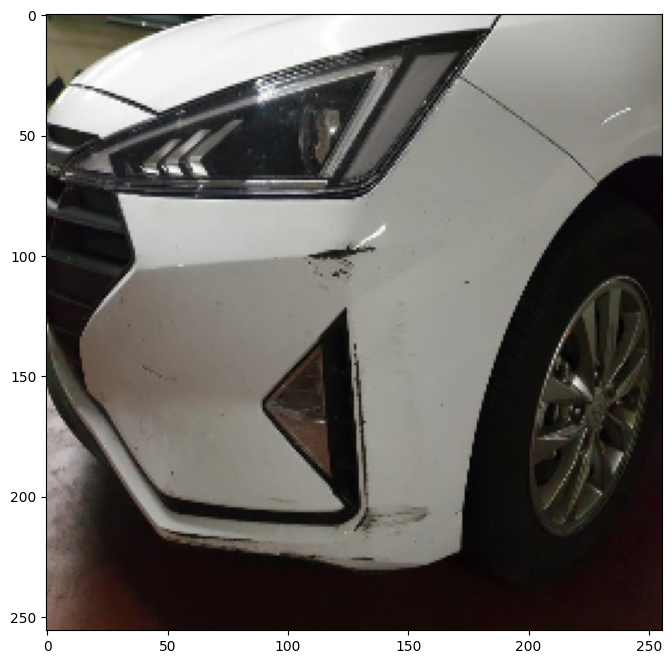

In [7]:
# img_path = 'samples/damage/0000002_as-0036229.jpg' # Breakage
img_path = 'samples/damage/0000565_sc-163434.jpg' # Scratch

# RGB 이미지 (256 x 256)
img  = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

plt.figure(figsize=(8, 8))
plt.imshow(img)

## 이미지 전처리

In [8]:
# 0-255 픽셀을 0-1로 normalization(255로 나누기)
# transpose로 채널 바꾸기
# Pytorch에 넣기 위해 채널을 맨앞으로 당겨줌(transpose; 타차원 텐서를 변형하는 작업) → [1,2,256,256] 형태의 Output
img_input = img / 255.
img_input = img_input.transpose([2, 0, 1])
img_input = torch.tensor(img_input).float().to(device)
img_input = img_input.unsqueeze(0)

img_input.shape

torch.Size([1, 3, 256, 256])

## 모델 추론

In [9]:
output = model(img_input)

output.shape

torch.Size([1, 2, 256, 256])

## 후처리 및 추론 마스크 시각화

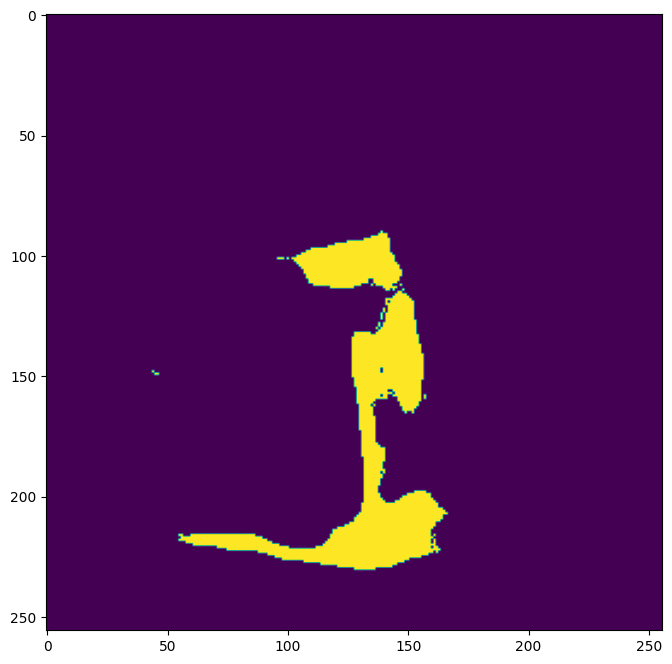

In [10]:
# 파손 영역만 시각화
img_output = torch.argmax(output, dim=1).detach().cpu().numpy()
img_output = img_output.transpose([1, 2, 0])

plt.figure(figsize=(8, 8))
plt.imshow(img_output)

## 결과

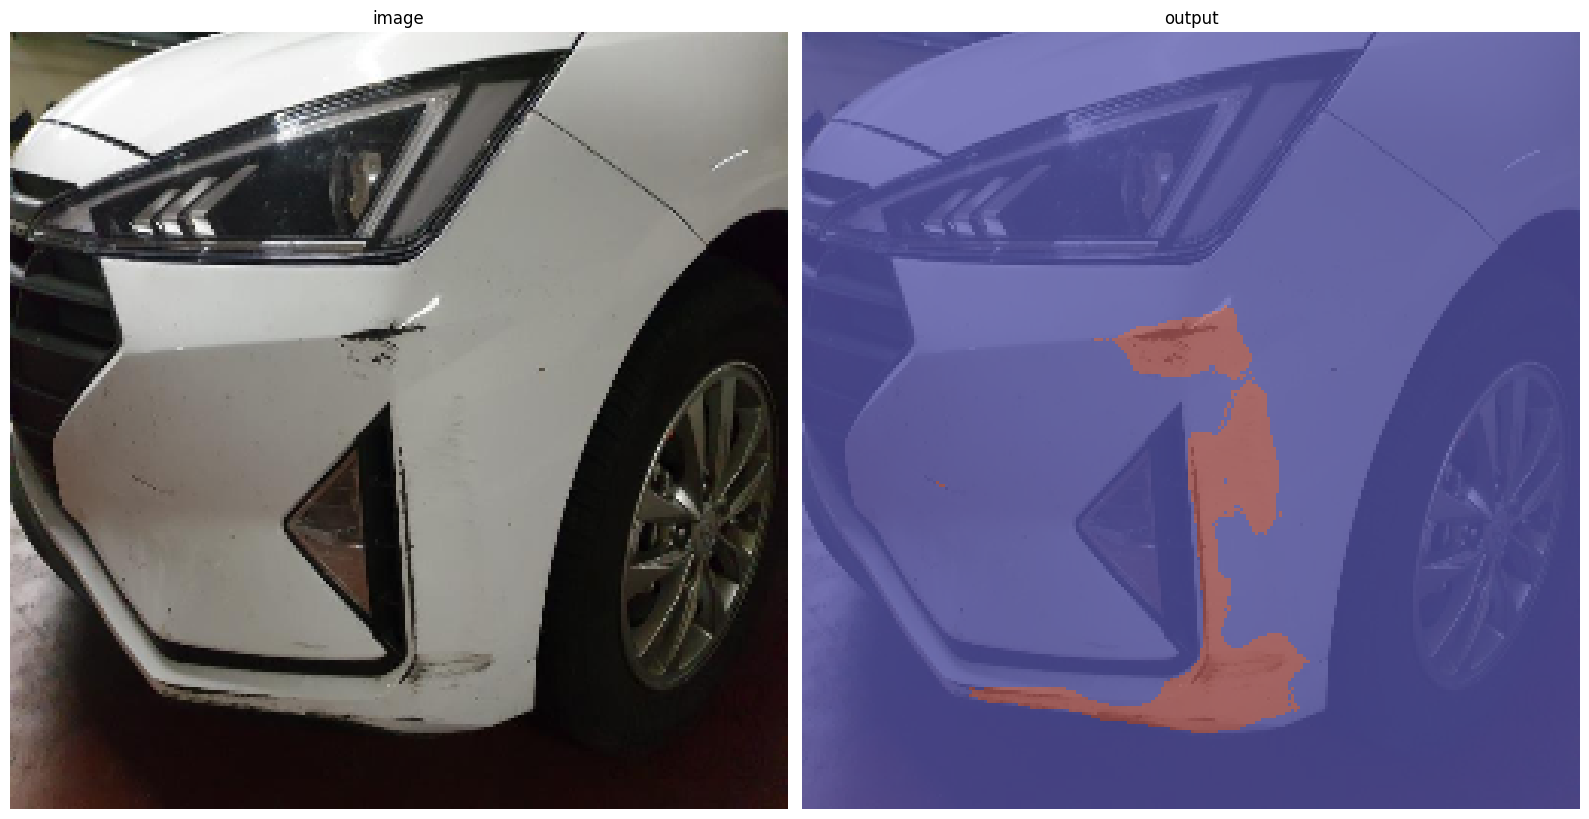

In [11]:
# 원본 이미지 위에 파손 영역 시각화를 올려 표기
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

ax[0].imshow(img)
ax[0].set_title('image')
ax[0].axis('off')

# unsigned 8bit integer(uint8)
# https://igotit.tistory.com/entry/%EC%A0%95%EC%88%98%ED%98%95-signed-unsigned-8-16-32-64%EB%B9%84%ED%8A%B8%EB%B3%84-%EA%B0%92-%ED%91%9C%ED%98%84-%EB%B2%94%EC%9C%84
ax[1].imshow(img.astype('uint8'), alpha=0.5)
ax[1].imshow(img_output, cmap='jet', alpha=0.5)
ax[1].set_title('output')
ax[1].axis('off')

fig.set_tight_layout(True)
plt.show()

# 여러 형태의 파손 영역 감지

In [12]:
# models = [] 리스트안에 로드해서 넣은 후 샘플 이미지의 파손 시각화
labels = ['Breakage_3', 'Crushed_2', 'Scratch_0', 'Seperated_1']
models = []

n_classes = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 이미지 로드 for문
for label in labels:
    model_path = f'models/[DAMAGE][{label}]Unet.pt'

    model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
    model.model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()

    models.append(model)

print('Loaded pretrained models!')

Loaded pretrained models!


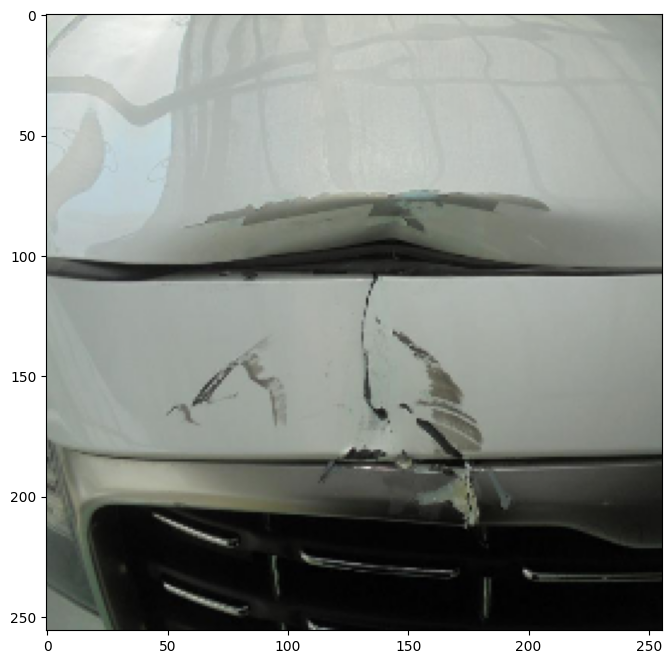

In [13]:
img_path = 'samples/damage/0000177_sc-153567.jpg'

img  = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

plt.figure(figsize=(8, 8))
plt.imshow(img)

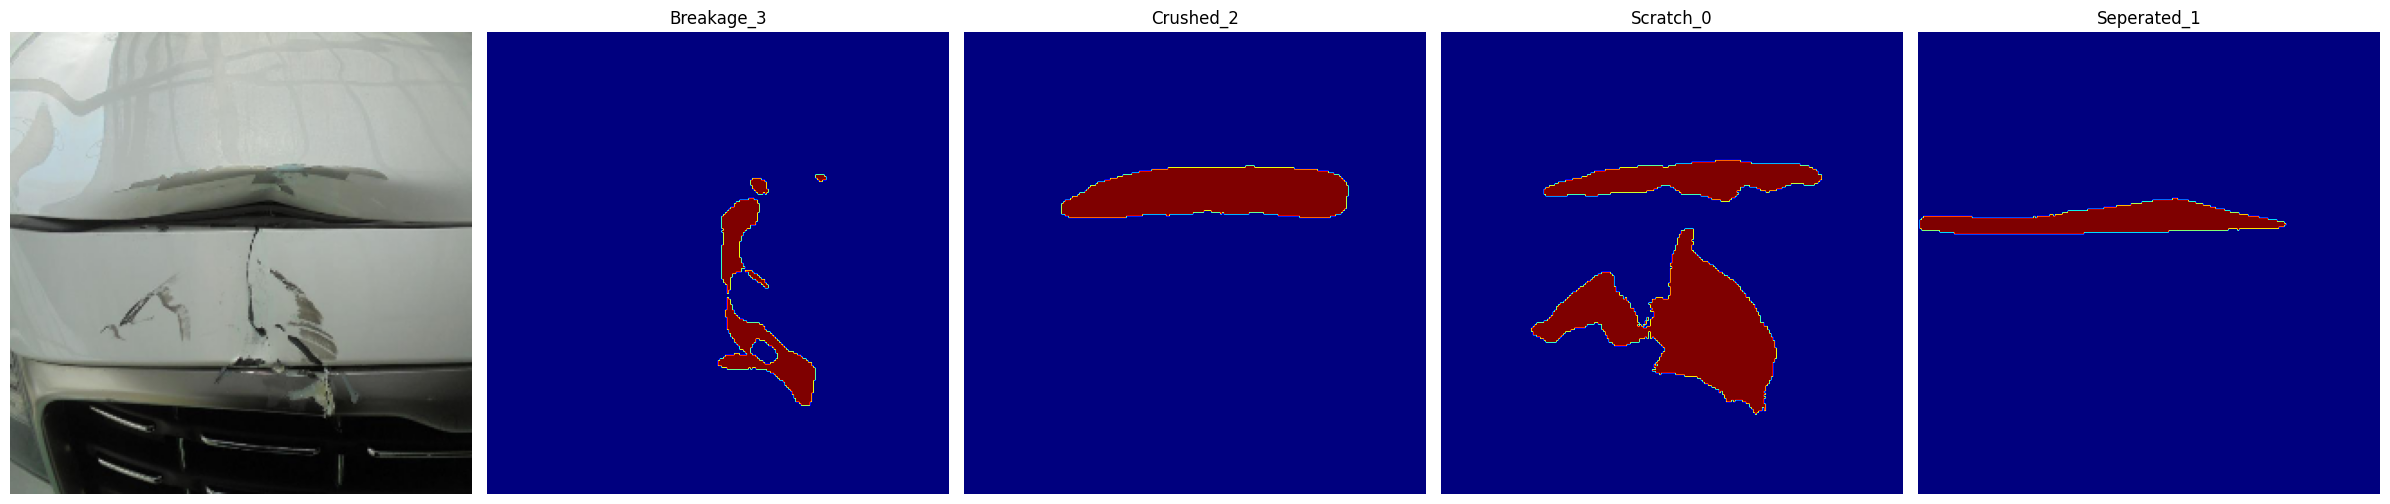

In [14]:
img_input = img / 255.
img_input = img_input.transpose([2, 0, 1])
img_input = torch.tensor(img_input).float().to(device)
img_input = img_input.unsqueeze(0)

fig, ax = plt.subplots(1, 5, figsize=(24, 10))

ax[0].imshow(img)
ax[0].axis('off')

outputs = []

for i, model in enumerate(models):
    output = model(img_input)

    img_output = torch.argmax(output, dim=1).detach().cpu().numpy()
    img_output = img_output.transpose([1, 2, 0])

    outputs.append(img_output)

    ax[i+1].set_title(labels[i])
    ax[i+1].imshow(img_output, cmap='jet')
    ax[i+1].axis('off')

fig.set_tight_layout(True)
plt.show()

##  파손 영역 크기 계산

In [ ]:
# 픽셀당 
for i, label in enumerate(labels):
    print(f'{label}: {outputs[i].sum()}')

Breakage_3: 1746
Crushed_2: 3702
Scratch_0: 7407
Seperated_1: 2297
